In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split, default_collate
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix
import pandas as pd
import torch.optim as optim
import torch
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import torch.optim.lr_scheduler as lr_scheduler
import torchvision
import cv2
from torchvision import datasets, transforms
from tqdm import tqdm  # Import tqdm for progress bar
from tempfile import TemporaryDirectory
from PIL import Image
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight






In [2]:
device = torch.device(device='cpu')
if torch.cuda.is_available():
  device = torch.device(device='cuda:0')
  pass

print(device)


cuda:0


In [3]:
dataset_dir = "Assignment\chest_xray\chest_xray"
# dataset_dir = "Assignment\Single_chest_Xray\chest_xray" 

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Jason\AppData\Local\Temp\ipykernel_18540\2279157877.py:1: SyntaxWarning: invalid escape sequence '\c'
  dataset_dir = "Assignment\chest_xray\chest_xray"


## Data Preprocessing

### Data before Data Preprocessing

In [4]:

simpleTrans = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((224, 224)),
])

# Load the training and testing data into a DataFrame
train_set = datasets.ImageFolder(os.path.join(dataset_dir,'train'), transform=simpleTrans)
val_set = datasets.ImageFolder(os.path.join(dataset_dir,'val'), transform=simpleTrans)
test_set = datasets.ImageFolder(os.path.join(dataset_dir,'test'), transform=simpleTrans)

train_loader = DataLoader(train_set, batch_size=16, num_workers=0, pin_memory=True, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=True)

dataloaders = {
  'train': train_loader,
  'val': val_loader,
  'test': test_loader
}

### Data Visualization

<Axes: xlabel='count'>

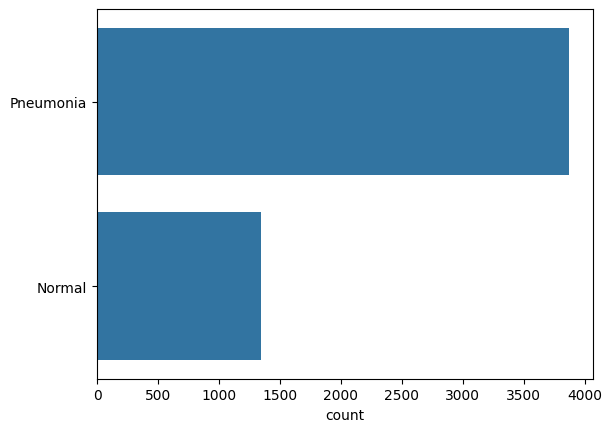

In [5]:
l = []
for _, labels in train_loader:
  for i in labels: 
    if(i == 1):
        l.append("Pneumonia")
    else:
        l.append("Normal")
# sns.set_style('darkgrid')
sns.countplot(l)     

In [6]:
train_set.class_to_idx

{'NORMAL': 0, 'PNEUMONIA': 1}

In [7]:
result_np = {
        'inputs': [],
        'labels': []
}
for inputs, labels in dataloaders['val']:  
  
  result_np['inputs'].append(inputs)
  result_np['labels'].append(labels.numpy())

result_np['inputs'][:1], result_np['labels'][:1]

([tensor([[[[0.8247, 0.8260, 0.8152,  ..., 0.8670, 0.8486, 0.8578],
            [0.8311, 0.8291, 0.8220,  ..., 0.8594, 0.8729, 0.8715],
            [0.8283, 0.8187, 0.8160,  ..., 0.8622, 0.8817, 0.8665],
            ...,
            [0.3223, 0.0957, 0.0733,  ..., 0.1146, 0.1224, 0.1185],
            [0.2484, 0.0878, 0.0759,  ..., 0.1173, 0.1248, 0.1203],
            [0.1947, 0.0821, 0.0781,  ..., 0.1174, 0.1250, 0.1205]],
  
           [[0.8247, 0.8260, 0.8152,  ..., 0.8670, 0.8486, 0.8578],
            [0.8311, 0.8291, 0.8220,  ..., 0.8594, 0.8729, 0.8715],
            [0.8283, 0.8187, 0.8160,  ..., 0.8622, 0.8817, 0.8665],
            ...,
            [0.3223, 0.0957, 0.0733,  ..., 0.1146, 0.1224, 0.1185],
            [0.2484, 0.0878, 0.0759,  ..., 0.1173, 0.1248, 0.1203],
            [0.1947, 0.0821, 0.0781,  ..., 0.1174, 0.1250, 0.1205]],
  
           [[0.8247, 0.8260, 0.8152,  ..., 0.8670, 0.8486, 0.8578],
            [0.8311, 0.8291, 0.8220,  ..., 0.8594, 0.8729, 0.8715],
      

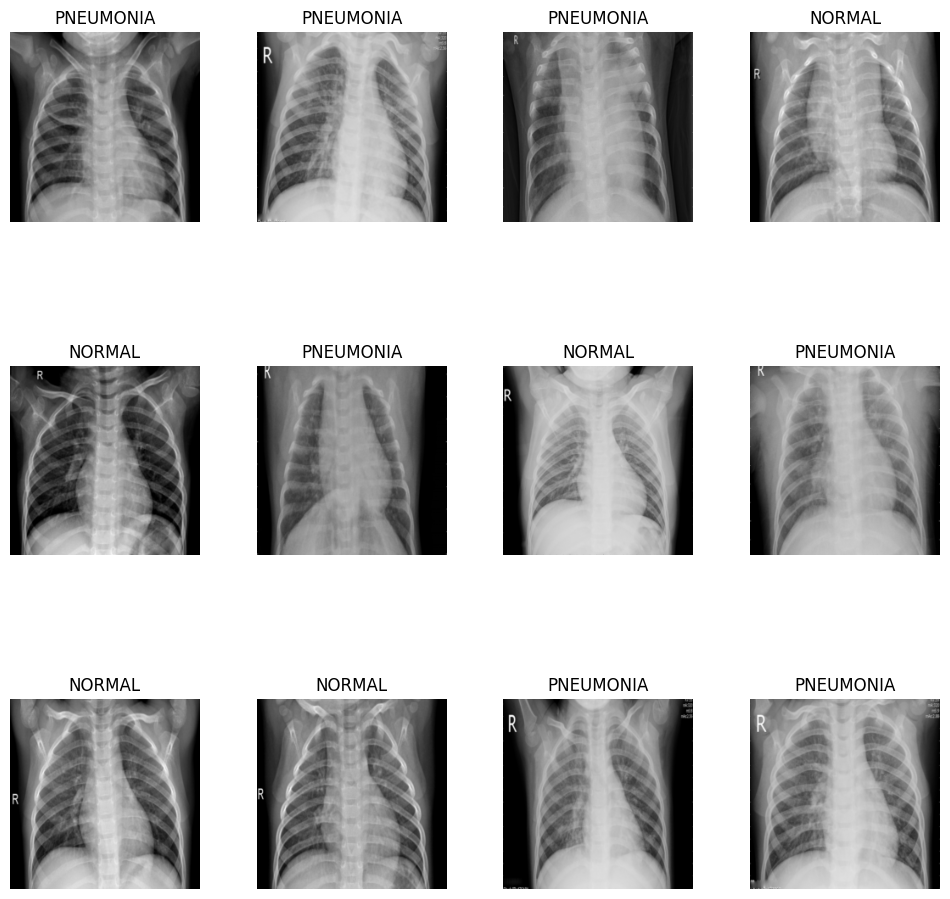

In [8]:
class_names = val_set.classes

fig, axes = plt.subplots(3, 4, figsize=(12, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(3):
    for j in range(4):
        inputs, classes = next(iter(dataloaders['val']))
        input_img = inputs[0]
        class_label = classes[0]    
           
        inp = input_img.numpy().transpose((1, 2, 0))                        
        inp = np.clip(inp, 0, 1)
        axes[i, j].imshow(inp)
        axes[i, j].set_title(class_names[class_label.item()])
        axes[i, j].axis('off')

plt.show()

### Histogram Equalization with CLAHE

In [9]:
class CLAHETransform:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img):
        # Convert PIL image to numpy array
        img_array = np.array(img)
        
        # Ensure the image is grayscale
        if len(img_array.shape) == 3 and img_array.shape[2] == 3:  # RGB Image
            img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)

        # Apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
        img_clahe = clahe.apply(img_array)

        # Convert back to PIL image
        return Image.fromarray(img_clahe)

## Data Augmentation

In [10]:
data_transform = {
  'train': transforms.Compose([
    CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8)),
    transforms.Resize((224, 224)),  
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),    
    transforms.ColorJitter(brightness=.5),
    transforms.RandomAdjustSharpness(2),
    transforms.ToTensor(),    
    transforms.Grayscale(num_output_channels=1),
    transforms.Normalize([0.5],[0.5]),   
  ]),
  'val': transforms.Compose([
    CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8)),
    transforms.Resize((224, 224)),   
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    # transforms.ColorJitter(brightness=.5),
    # transforms.RandomAdjustSharpness(2),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Normalize([0.5],[0.5])        
  ]),
  'test':transforms.Compose([
    CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8)),
    transforms.Resize((224, 224)),    
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    # transforms.ColorJitter(brightness=.5),
    # transforms.RandomAdjustSharpness(2),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Normalize([0.5],[0.5]),        
  ]),
  'overall':transforms.Compose([
  transforms.Resize((224,224)),
  transforms.ToTensor()
])
}   


# Load the training and testing data into a DataFrame
train_set = datasets.ImageFolder(os.path.join(dataset_dir,'train'), transform=data_transform['train'])
val_set = datasets.ImageFolder(os.path.join(dataset_dir,'val'),transform=data_transform['val'])
test_set = datasets.ImageFolder(os.path.join(dataset_dir,'test'),transform=data_transform['test'])

dataset_sizes = {}
dataset_sizes['train'] = len(train_set)
dataset_sizes['val'] = len(val_set)

# Data loaders
BATCH_SIZE = 32

train_loader = DataLoader(train_set, batch_size=32, num_workers=0, pin_memory=True, shuffle=True)
val_loader = DataLoader(val_set, batch_size=2, shuffle=True)
test_loader = DataLoader(test_set, batch_size=2, shuffle=True)

dataloaders = {
  'train': train_loader,
  'val': val_loader,
  'test': test_loader
}



In [11]:
len(train_set)

5216

### Data After Preprocessing

In [12]:
# Get the class names from the training dataset
class_names = train_set.classes

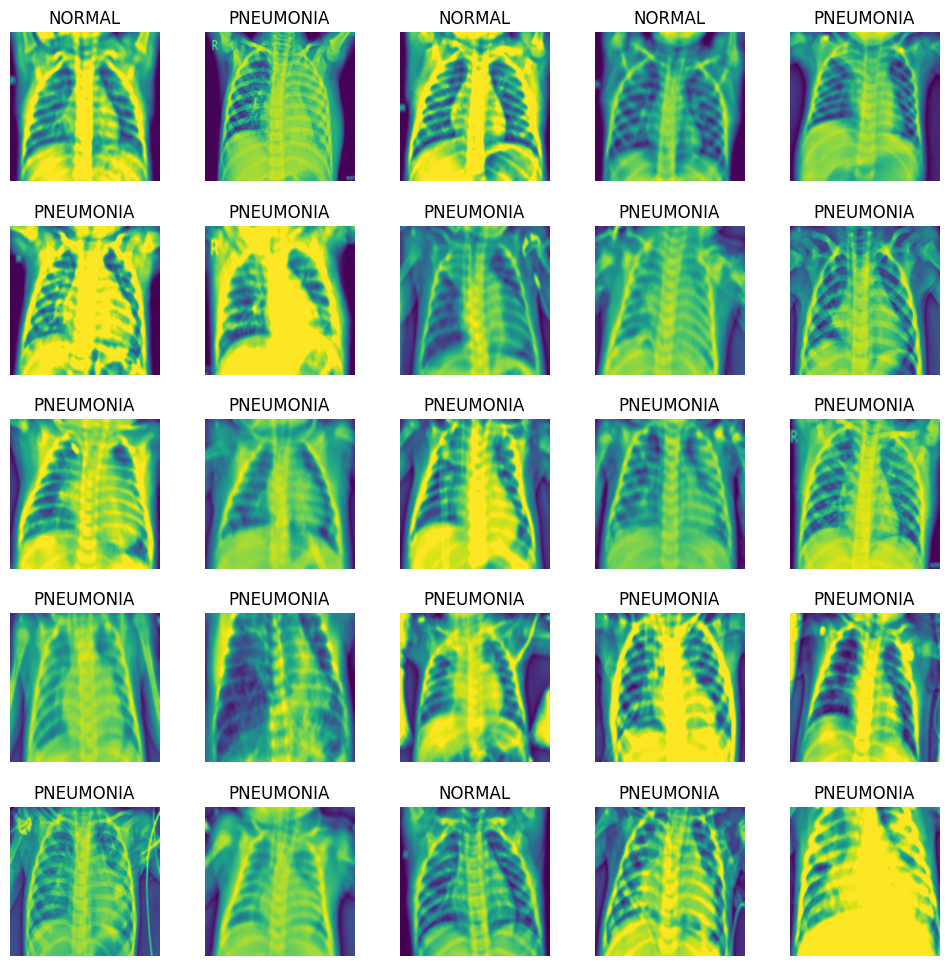

In [13]:
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(5):
    for j in range(5):
        inputs, classes = next(iter(dataloaders['train']))
        input_img = inputs[0]
        class_label = classes[0]    

        inp = input_img.numpy().transpose((1, 2, 0))
        #print('after: ', inp)
        # inp = input_img.numpy()              
        # mean = np.array([0.485, 0.456, 0.406])
        # std = np.array([0.229, 0.224, 0.225])
        mean = 0.5
        std = 0.5
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        axes[i, j].imshow(inp)
        axes[i, j].set_title(class_names[class_label.item()])
        axes[i, j].axis('off')

plt.show()

## Transfer Learning for Base Model

In [14]:
# Get the ResNet50 base model
resnet50 = torchvision.models.resnet50(pretrained=True)
resnet18 = torchvision.models.resnet18(pretrained=True)
effNetB3 = torchvision.models.efficientnet_b3()

#resnet50.eval().to(device)

models = {
  "resnet50": resnet50,
  "resnet18": resnet18,
  "effNetB3": effNetB3
}

c:\Users\Jason\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Jason\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Jason\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.

### For Grayscale image

In [15]:
def convert_grayScale(model):
    # Modify the first convolutional layer
    original_conv = model.conv1  # Get the original first convolution layer

    # Create a new convolutional layer with 1 input channel (for grayscale images)
    new_conv = nn.Conv2d(
        in_channels=1,  # Grayscale image
        out_channels=original_conv.out_channels,  # Keep the same number of output channels
        kernel_size=original_conv.kernel_size,
        stride=original_conv.stride,
        padding=original_conv.padding,
        bias=original_conv.bias is not None  # Retain bias if present
    )

    # Copy the weights from the original layer, averaging across the RGB channels
    with torch.no_grad():
        new_conv.weight[:, 0] = original_conv.weight.mean(dim=1)  # Average RGB weights
        if original_conv.bias is not None:
            new_conv.bias = original_conv.bias  # Copy the bias

    # Replace the original convolutional layer with the new one
    model.conv1 = new_conv
    
    return model

In [16]:
models["resnet50"] = convert_grayScale(resnet50)
models["resnet18"] = convert_grayScale(resnet18)

In [17]:
def freezeLayers(model):
    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last layer
    for param in model.fc.parameters():
        param.requires_grad = True
    
    

In [18]:
freezeLayers(models["resnet18"])
freezeLayers(models["resnet50"])

In [19]:
# Replace the last block (layer4) in ResNet-50
resnet50.layer4 = nn.Sequential(
    nn.Conv2d(1024, 512, kernel_size=3, padding=1),  # Custom convolution
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2)
)

# Replace the last block (layer4) in ResNet-18
resnet18.layer4 = nn.Sequential(
    nn.Conv2d(256, 128, kernel_size=3, padding=1),  # Custom convolution
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),   
)


In [20]:
def changeLayerFeature(model, input_features):
  # num_ftrs = model.fc.in_features
  model.fc = nn.Sequential(
    nn.Linear(input_features, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(inplace=True),
    nn.Dropout(0.4),    
    nn.Linear(64, 16),
    nn.BatchNorm1d(16),
    nn.ReLU(inplace=True),
    nn.Dropout(0.4),
    nn.Linear(16,2),
  )

In [21]:
changeLayerFeature(models["resnet18"], 128)
changeLayerFeature(models["resnet50"], 512)

## Self defined Model

In [22]:
import torch.nn.functional as F

class PneumoniaDetectionModel(nn.Module):
    def __init__(self, img_size):
        super(PneumoniaDetectionModel, self).__init__()
        
        self.debugXShape = {}

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # self.dropout1 = nn.Dropout(0.1)
        self.dropout1 = nn.Dropout(0.5)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        # self.bn3 = nn.BatchNorm2d(64)
        # self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        # # self.dropout2 = nn.Dropout(0.2)
        # self.dropout2 = nn.Dropout(0.3)
        # self.bn4 = nn.BatchNorm2d(128)
        # self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        # # self.dropout3 = nn.Dropout(0.2)
        # self.dropout3 = nn.Dropout(0.3)
        # self.bn5 = nn.BatchNorm2d(256)
        # self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        
        # Assuming the flattened input size after pooling layers is known
        flattened_size = (img_size // 32) * (img_size // 32) * 256 * 8 * 2
        self.fc1 = nn.Linear(flattened_size, 64)
        # self.dropout4 = nn.Dropout(0.2)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        
        # self.debugXShape is used to store the shape of images at each convolution layer for debug purpose

        self.debugXShape["0"] = x.shape
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        self.debugXShape["1"] = x.shape
        x = F.relu(self.bn2(self.dropout1(self.conv2(x))))
        x = self.pool2(x)

        # self.debugXShape["2"] = x.shape
        # x = F.relu(self.bn3(self.conv3(x)))
        # x = self.pool3(x)

        # self.debugXShape["3"] = x.shape
        # x = F.relu(self.bn4(self.dropout2(self.conv4(x))))
        # x = self.pool4(x)

        # self.debugXShape["4"] = x.shape
        # x = F.relu(self.bn5(self.dropout3(self.conv5(x))))
        # x = self.pool5(x)

        self.debugXShape["5"] = x.shape
        x = self.flatten(x)        

        self.debugXShape["Flatten"] = x.shape        
        x = F.relu(self.fc1(x))

        self.debugXShape["Linear"] = x.shape
        x = self.dropout4(x)
        x = torch.sigmoid(self.fc2(x))
        

        self.debugXShape["End"] = x.shape

        # for kvp in self.debugXShape:
        #     print(f"{kvp}: {self.debugXShape[kvp]}")
        
        return x



## Model Choice

In [23]:
# Instantiate the model
img_size = 224  # Example image size, modify based on your data
pneumoniaDetectionModel = PneumoniaDetectionModel(img_size=img_size)

models["resnet18"] = nn.DataParallel(models["resnet18"])
models["resnet50"] = nn.DataParallel(models["resnet50"])
models["self"] = nn.DataParallel(pneumoniaDetectionModel)

models["resnet18"] = models["resnet18"].to(device)
models["resnet50"] = models["resnet50"].to(device)
models["self"] = models["self"].to(device)


In [24]:
def train(model, criterion, optimizer, scheduler, num_epochs=15):
    
    metrics_dict = {
        "train": {
            "loss": [],
            "acc": [],
        },
        "val": {
            "loss": [],
            "acc": []
        }
    }    

    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            dataloaders['train'] = tqdm(dataloaders['train'], desc=f"Epoch {epoch+1}/{num_epochs}")
            dataloaders['val'] = tqdm(dataloaders['val'], desc=f"Epoch {epoch+1}/{num_epochs}")                        

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode (Disabling dropout and batch normalization)

                running_loss = 0.0
                running_corrects = 0
                count = 0
                # Iterate over data.
                for inputs, labels in dataloaders[phase]:                    
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)                       
                        _, preds = torch.max(outputs, 1) # For CrossEntropyLoss
                        # preds  = F.one_hot(preds, num_classes=2).float()
                        # labels = F.one_hot(labels, num_classes=2).float()  # Convert to one-hot and float for BCELoss                                           
                        
                        #loss = criterion(outputs, labels.float()) 
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)                                                             
                    running_corrects += torch.sum(preds == labels)
                    #running_corrects += (torch.sum(preds.float() == labels) / 2 )
                    
                if phase == 'train':
                    scheduler.step()
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                                
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                metrics_dict[phase]['loss'].append(epoch_loss)
                metrics_dict[phase]['acc'].append(epoch_acc)

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, metrics_dict

In [25]:
def drawGraph(results):

  # draw graph at here
  fig, axs = plt.subplots(1, 2, figsize=(8, 4))
  axs = axs.flatten()
  training_loss = results["training_loss"]  # Sample decreasing values
  validating_loss = results["validating_loss"]

  # Plotting Training and Testing Loss
  axs[0].plot(range(results["stopping_epoch"]), training_loss, label="Training Loss", color='red')
  axs[0].plot(range(results["stopping_epoch"]), validating_loss, label="Validating Loss", color='blue')

  axs[0].legend(loc='best')
  axs[0].set_title("Training, Validating Loss over Epochs")

  training_accuracy = results["training_accuracy"]  # Increasing accuracy
  validating_accuracy = results["validating_accuracy"]

  for idx, tensorItem in enumerate(training_accuracy): 
    training_accuracy[idx] = tensorItem.cpu()    # Move tensor to CPU

  for idx, tensorItem in enumerate(validating_accuracy):
    validating_accuracy[idx] = tensorItem.cpu()

  print(type(training_accuracy))

  # Plotting Training and Testing Accuracy
  axs[1].plot(range(results["stopping_epoch"]), training_accuracy, label="Training Accuracy", color='red')
  axs[1].plot(range(results["stopping_epoch"]), validating_accuracy, label="Validating Accuracy", color='blue')
  axs[1].legend(loc='best')
  axs[1].set_title("Training, Validating Accuracy over Epochs")



  plt.tight_layout()
  #plt.legend(loc='best')
  plt.grid(True)
  plt.show()

In [26]:
def predict(testLoader, model_ft):
    result_np = {
        'preds': [],
        'labels': []
    }

    model_ft.eval()           
    with torch.set_grad_enabled(False):
        for inputs, labels in testLoader:
            outputs = model_ft(inputs)           
            _, preds = torch.max(outputs, 1)                                    
            pred_np = preds.cpu().detach().numpy()            
            result_np['preds'].append(pred_np)
            result_np['labels'].append(labels.numpy())
            
    return result_np

In [27]:
def plot_multiple_confusion_matrices(cms, class_names, titles):
    """
    Plots multiple confusion matrices as subplots.

    Args:
        cms: List of confusion matrices (numpy arrays).
        class_names: List of class names corresponding to the confusion matrices.
        titles: List of titles for each subplot.
    """
    num_matrices = len(cms)
    rows = (num_matrices + 1) // 2  # Determine rows based on number of matrices (2 per row)
    cols = 2  # Number of columns per row

    fig, axes = plt.subplots(rows, cols, figsize=(12, 6 * rows))
    axes = axes.flatten()  # Flatten axes for easy indexing

    for i, cm in enumerate(cms):        
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(ax=axes[i], cmap='viridis', colorbar=False)  # Plot on each axis
        axes[i].set_title(titles[i])
        axes[i].grid(False)  # Disable gridlines for a cleaner look

    # Remove unused axes if cms count < rows * cols
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()






In [28]:
def evaluation(model, lr, momentum, weight_decay, num_epochs):

  # Start training
  class_weights = compute_class_weight("balanced", classes=np.unique(train_set.targets), y=train_set.targets)
  class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

  criterion = nn.CrossEntropyLoss(weight=class_weights)
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
  exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
  model_ft, metrics = train(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

  result = {
    'training_loss': metrics['train']['loss'],
    'training_accuracy': metrics['train']['acc'],
    'validating_loss': metrics['val']['loss'],
    'validating_accuracy': metrics['val']['acc'],
    'epochs': num_epochs,
    'stopping_epoch': num_epochs
  }

  # Graph showing average accuracies and losses over epoch
  drawGraph(result)

  # Prediction with best model
  pred_result = predict(dataloaders['test'], models['self'])

  # Classification Report
  print(classification_report(pred_result['labels'], pred_result['preds']))

  # Construct Confusion Matrix
  cm = multilabel_confusion_matrix(pred_result['labels'], pred_result['preds'])

  class_names = ['Normal','Pneumonia']

  titles = ['Confusion Matrix 1', 'Confusion Matrix 2']

  # Plotting the confusion matrices
  plot_multiple_confusion_matrices(cm, class_names, titles)

  total_params = sum(p.numel() for p in model_ft.parameters())

  print(f"Number of parameters: {total_params}")

  return model_ft, result

Epoch 1/30: 100%|██████████| 163/163 [01:19<00:00,  2.06it/s]


train Loss: 0.6571 Acc: 0.5717


Epoch 1/30: 100%|██████████| 144/144 [01:23<00:00,  1.73it/s]


val Loss: 0.6410 Acc: 0.8090



Epoch 2/30: 100%|██████████| 163/163 [01:16<00:00,  2.12it/s]


train Loss: 0.5744 Acc: 0.8050


Epoch 2/30: 100%|██████████| 144/144 [01:20<00:00,  1.79it/s]


val Loss: 0.5999 Acc: 0.8507



Epoch 3/30: 100%|██████████| 163/163 [01:15<00:00,  2.16it/s]


train Loss: 0.5305 Acc: 0.8510


Epoch 3/30: 100%|██████████| 144/144 [01:19<00:00,  1.81it/s]


val Loss: 0.5674 Acc: 0.8542



Epoch 4/30: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]


train Loss: 0.5049 Acc: 0.8708


Epoch 4/30: 100%|██████████| 144/144 [01:24<00:00,  1.71it/s]


val Loss: 0.5579 Acc: 0.8576



Epoch 5/30: 100%|██████████| 163/163 [01:18<00:00,  2.07it/s]


train Loss: 0.4865 Acc: 0.8808


Epoch 5/30: 100%|██████████| 144/144 [01:22<00:00,  1.75it/s]


val Loss: 0.5441 Acc: 0.8576



Epoch 6/30: 100%|██████████| 163/163 [01:15<00:00,  2.16it/s]


train Loss: 0.4753 Acc: 0.8917


Epoch 6/30: 100%|██████████| 144/144 [01:19<00:00,  1.82it/s]


val Loss: 0.5368 Acc: 0.8472



Epoch 7/30: 100%|██████████| 163/163 [01:18<00:00,  2.09it/s]


train Loss: 0.4664 Acc: 0.8946


Epoch 7/30: 100%|██████████| 144/144 [01:21<00:00,  1.76it/s]


val Loss: 0.5280 Acc: 0.8368



Epoch 8/30: 100%|██████████| 163/163 [01:20<00:00,  2.04it/s]


train Loss: 0.4536 Acc: 0.9066


Epoch 8/30: 100%|██████████| 144/144 [01:24<00:00,  1.71it/s]


val Loss: 0.5299 Acc: 0.8333



Epoch 9/30: 100%|██████████| 163/163 [01:20<00:00,  2.03it/s]


train Loss: 0.4485 Acc: 0.9057


Epoch 9/30: 100%|██████████| 144/144 [01:24<00:00,  1.70it/s]


val Loss: 0.5257 Acc: 0.8507



Epoch 10/30: 100%|██████████| 163/163 [01:18<00:00,  2.08it/s]


train Loss: 0.4414 Acc: 0.9107


Epoch 10/30: 100%|██████████| 144/144 [01:22<00:00,  1.75it/s]


val Loss: 0.5237 Acc: 0.8472



Epoch 11/30: 100%|██████████| 163/163 [01:20<00:00,  2.03it/s]


train Loss: 0.4350 Acc: 0.9199


Epoch 11/30: 100%|██████████| 144/144 [01:24<00:00,  1.71it/s]


val Loss: 0.5241 Acc: 0.8472



Epoch 12/30: 100%|██████████| 163/163 [01:20<00:00,  2.04it/s]


train Loss: 0.4362 Acc: 0.9143


Epoch 12/30: 100%|██████████| 144/144 [01:24<00:00,  1.71it/s]


val Loss: 0.5277 Acc: 0.8542



Epoch 13/30: 100%|██████████| 163/163 [01:20<00:00,  2.03it/s]


train Loss: 0.4371 Acc: 0.9189


Epoch 13/30: 100%|██████████| 144/144 [01:24<00:00,  1.71it/s]


val Loss: 0.5234 Acc: 0.8438



Epoch 14/30: 100%|██████████| 163/163 [01:20<00:00,  2.03it/s]


train Loss: 0.4352 Acc: 0.9168


Epoch 14/30: 100%|██████████| 144/144 [01:24<00:00,  1.71it/s]


val Loss: 0.5235 Acc: 0.8403



Epoch 15/30: 100%|██████████| 163/163 [01:17<00:00,  2.10it/s]


train Loss: 0.4350 Acc: 0.9187


Epoch 15/30: 100%|██████████| 144/144 [01:21<00:00,  1.77it/s]


val Loss: 0.5247 Acc: 0.8403



Epoch 16/30: 100%|██████████| 163/163 [01:16<00:00,  2.14it/s]


train Loss: 0.4349 Acc: 0.9206


Epoch 16/30: 100%|██████████| 144/144 [01:19<00:00,  1.80it/s]


val Loss: 0.5275 Acc: 0.8507



Epoch 17/30: 100%|██████████| 163/163 [01:15<00:00,  2.15it/s]


train Loss: 0.4355 Acc: 0.9151


Epoch 17/30: 100%|██████████| 144/144 [01:19<00:00,  1.81it/s]


val Loss: 0.5210 Acc: 0.8472



Epoch 18/30: 100%|██████████| 163/163 [01:16<00:00,  2.14it/s]


train Loss: 0.4328 Acc: 0.9199


Epoch 18/30: 100%|██████████| 144/144 [01:19<00:00,  1.81it/s]


val Loss: 0.5240 Acc: 0.8403



Epoch 19/30: 100%|██████████| 163/163 [01:16<00:00,  2.13it/s]


train Loss: 0.4332 Acc: 0.9183


Epoch 19/30: 100%|██████████| 144/144 [01:20<00:00,  1.80it/s]


val Loss: 0.5177 Acc: 0.8403



Epoch 20/30: 100%|██████████| 163/163 [01:15<00:00,  2.15it/s]


train Loss: 0.4322 Acc: 0.9187


Epoch 20/30: 100%|██████████| 144/144 [01:19<00:00,  1.81it/s]


val Loss: 0.5229 Acc: 0.8403



Epoch 21/30: 100%|██████████| 163/163 [01:17<00:00,  2.10it/s]


train Loss: 0.4312 Acc: 0.9256


Epoch 21/30: 100%|██████████| 144/144 [01:21<00:00,  1.76it/s]


val Loss: 0.5202 Acc: 0.8438



Epoch 22/30: 100%|██████████| 163/163 [01:20<00:00,  2.04it/s]



train Loss: 0.4315 Acc: 0.9193


Epoch 22/30: 100%|██████████| 144/144 [01:24<00:00,  1.71it/s]


val Loss: 0.5243 Acc: 0.8472



Epoch 23/30: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]


train Loss: 0.4355 Acc: 0.9158


Epoch 23/30: 100%|██████████| 144/144 [01:23<00:00,  1.72it/s]


val Loss: 0.5202 Acc: 0.8368



Epoch 24/30: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]


train Loss: 0.4311 Acc: 0.9227


Epoch 24/30: 100%|██████████| 144/144 [01:23<00:00,  1.72it/s]


val Loss: 0.5253 Acc: 0.8507



Epoch 25/30: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]


train Loss: 0.4325 Acc: 0.9206


Epoch 25/30: 100%|██████████| 144/144 [01:24<00:00,  1.71it/s]


val Loss: 0.5255 Acc: 0.8472



Epoch 26/30: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]


train Loss: 0.4316 Acc: 0.9197


Epoch 26/30: 100%|██████████| 144/144 [01:23<00:00,  1.73it/s]


val Loss: 0.5217 Acc: 0.8403



Epoch 27/30: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]


train Loss: 0.4342 Acc: 0.9176


Epoch 27/30: 100%|██████████| 144/144 [01:23<00:00,  1.73it/s]


val Loss: 0.5293 Acc: 0.8576



Epoch 28/30: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]


train Loss: 0.4324 Acc: 0.9208


Epoch 28/30: 100%|██████████| 144/144 [01:23<00:00,  1.72it/s]


val Loss: 0.5248 Acc: 0.8438



Epoch 29/30: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]


train Loss: 0.4320 Acc: 0.9185


Epoch 29/30: 100%|██████████| 144/144 [01:23<00:00,  1.73it/s]


val Loss: 0.5250 Acc: 0.8403



Epoch 30/30: 100%|██████████| 163/163 [01:19<00:00,  2.06it/s]


train Loss: 0.4331 Acc: 0.9193


Epoch 30/30: 100%|██████████| 144/144 [01:23<00:00,  1.73it/s]


val Loss: 0.5196 Acc: 0.8403

Training complete in 41m 14s
Best val Acc: 0.857639
<class 'list'>


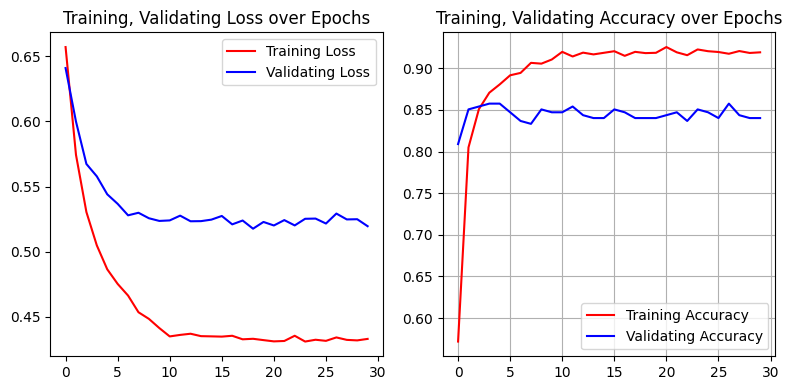

              precision    recall  f1-score   support

           0       0.93      0.84      0.88       107
           1       0.93      0.89      0.91       113

   micro avg       0.93      0.87      0.90       220
   macro avg       0.93      0.87      0.90       220
weighted avg       0.93      0.87      0.90       220
 samples avg       0.78      0.74      0.75       220



c:\Users\Jason\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jason\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jason\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

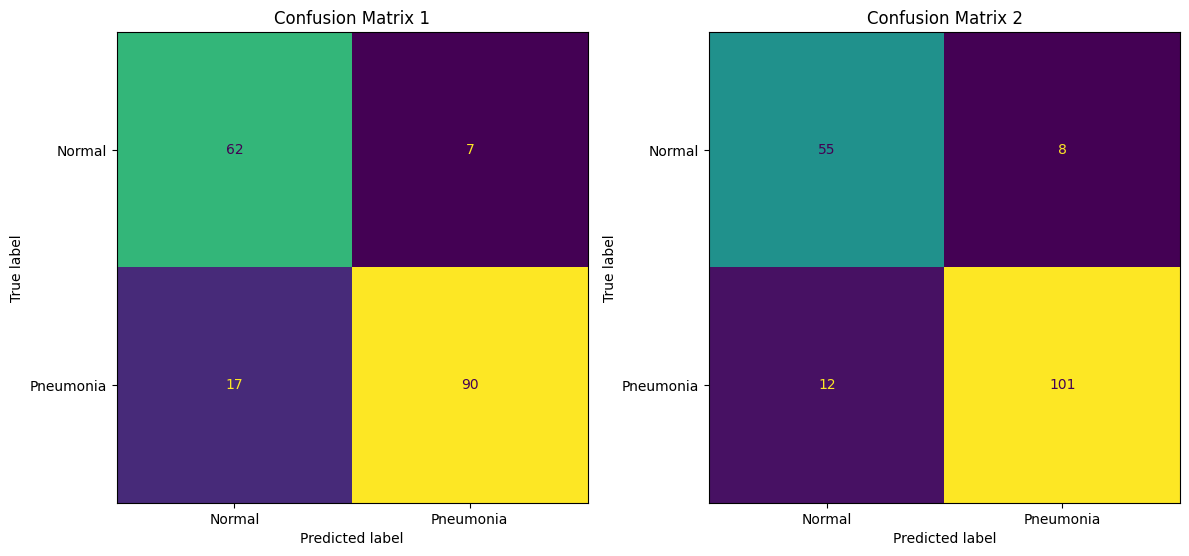

Number of parameters: 12864258


In [29]:
results = {
  'self': {},
  'resnet18': {},
  'resnet50' : {}
}

models['self'], results['self'] = evaluation(models["self"], lr=0.00001, momentum=0.9, weight_decay=1e-2, num_epochs=30)

Epoch 1/30:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 1/30: 100%|██████████| 163/163 [01:18<00:00,  2.08it/s]


train Loss: 0.6366 Acc: 0.5019


Epoch 1/30: 100%|██████████| 144/144 [01:23<00:00,  1.73it/s]


val Loss: 0.5383 Acc: 0.7049



Epoch 2/30: 100%|██████████| 163/163 [01:18<00:00,  2.06it/s]


train Loss: 0.4846 Acc: 0.6887


Epoch 2/30: 100%|██████████| 144/144 [01:22<00:00,  1.74it/s]


val Loss: 0.4812 Acc: 0.8333



Epoch 3/30: 100%|██████████| 163/163 [01:18<00:00,  2.07it/s]


train Loss: 0.4254 Acc: 0.7797


Epoch 3/30: 100%|██████████| 144/144 [01:22<00:00,  1.74it/s]


val Loss: 0.4468 Acc: 0.8507



Epoch 4/30: 100%|██████████| 163/163 [01:17<00:00,  2.11it/s]


train Loss: 0.3832 Acc: 0.8319


Epoch 4/30: 100%|██████████| 144/144 [01:21<00:00,  1.76it/s]


val Loss: 0.4298 Acc: 0.8715



Epoch 5/30: 100%|██████████| 163/163 [01:18<00:00,  2.07it/s]


train Loss: 0.3543 Acc: 0.8740


Epoch 5/30: 100%|██████████| 144/144 [01:22<00:00,  1.74it/s]


val Loss: 0.4257 Acc: 0.8785



Epoch 6/30: 100%|██████████| 163/163 [01:15<00:00,  2.16it/s]


train Loss: 0.3308 Acc: 0.8961


Epoch 6/30: 100%|██████████| 144/144 [01:19<00:00,  1.81it/s]


val Loss: 0.4243 Acc: 0.8750



Epoch 7/30: 100%|██████████| 163/163 [01:13<00:00,  2.21it/s]


train Loss: 0.3145 Acc: 0.9062


Epoch 7/30: 100%|██████████| 144/144 [01:17<00:00,  1.85it/s]


val Loss: 0.3993 Acc: 0.8993



Epoch 8/30: 100%|██████████| 163/163 [01:12<00:00,  2.23it/s]


train Loss: 0.3027 Acc: 0.9183


Epoch 8/30: 100%|██████████| 144/144 [01:16<00:00,  1.89it/s]


val Loss: 0.4091 Acc: 0.8854



Epoch 9/30: 100%|██████████| 163/163 [01:14<00:00,  2.18it/s]


train Loss: 0.2861 Acc: 0.9266


Epoch 9/30: 100%|██████████| 144/144 [01:19<00:00,  1.81it/s]


val Loss: 0.3835 Acc: 0.9062



Epoch 10/30: 100%|██████████| 163/163 [01:18<00:00,  2.09it/s]


train Loss: 0.2675 Acc: 0.9321


Epoch 10/30: 100%|██████████| 144/144 [01:21<00:00,  1.77it/s]


val Loss: 0.3652 Acc: 0.9028



Epoch 11/30: 100%|██████████| 163/163 [01:17<00:00,  2.10it/s]


train Loss: 0.2656 Acc: 0.9333


Epoch 11/30: 100%|██████████| 144/144 [01:21<00:00,  1.78it/s]


val Loss: 0.3768 Acc: 0.9028



Epoch 12/30: 100%|██████████| 163/163 [01:17<00:00,  2.09it/s]


train Loss: 0.2528 Acc: 0.9339


Epoch 12/30: 100%|██████████| 144/144 [01:22<00:00,  1.75it/s]


val Loss: 0.3926 Acc: 0.8993



Epoch 13/30: 100%|██████████| 163/163 [01:21<00:00,  2.00it/s]


train Loss: 0.2610 Acc: 0.9400


Epoch 13/30: 100%|██████████| 144/144 [01:25<00:00,  1.69it/s]


val Loss: 0.3800 Acc: 0.9028



Epoch 14/30: 100%|██████████| 163/163 [01:20<00:00,  2.02it/s]


train Loss: 0.2621 Acc: 0.9387


Epoch 14/30: 100%|██████████| 144/144 [01:24<00:00,  1.70it/s]


val Loss: 0.3836 Acc: 0.8958



Epoch 15/30: 100%|██████████| 163/163 [01:19<00:00,  2.06it/s]


train Loss: 0.2552 Acc: 0.9350


Epoch 15/30: 100%|██████████| 144/144 [01:23<00:00,  1.73it/s]


val Loss: 0.3737 Acc: 0.9062



Epoch 16/30: 100%|██████████| 163/163 [01:20<00:00,  2.03it/s]


train Loss: 0.2616 Acc: 0.9394


Epoch 16/30: 100%|██████████| 144/144 [01:24<00:00,  1.71it/s]


val Loss: 0.3851 Acc: 0.8854



Epoch 17/30: 100%|██████████| 163/163 [01:19<00:00,  2.06it/s]


train Loss: 0.2582 Acc: 0.9367


Epoch 17/30: 100%|██████████| 144/144 [01:23<00:00,  1.73it/s]


val Loss: 0.3928 Acc: 0.8958



Epoch 18/30: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]


train Loss: 0.2543 Acc: 0.9369


Epoch 18/30: 100%|██████████| 144/144 [01:23<00:00,  1.73it/s]


val Loss: 0.4066 Acc: 0.8646



Epoch 19/30: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]


train Loss: 0.2579 Acc: 0.9316


Epoch 19/30: 100%|██████████| 144/144 [01:23<00:00,  1.72it/s]


val Loss: 0.3928 Acc: 0.8889



Epoch 20/30: 100%|██████████| 163/163 [01:21<00:00,  2.01it/s]


train Loss: 0.2575 Acc: 0.9415


Epoch 20/30: 100%|██████████| 144/144 [01:25<00:00,  1.69it/s]


val Loss: 0.3750 Acc: 0.8993



Epoch 21/30: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]


train Loss: 0.2490 Acc: 0.9417


Epoch 21/30: 100%|██████████| 144/144 [01:23<00:00,  1.72it/s]


val Loss: 0.3956 Acc: 0.8889



Epoch 22/30: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]


train Loss: 0.2453 Acc: 0.9427


Epoch 22/30: 100%|██████████| 144/144 [01:23<00:00,  1.72it/s]


val Loss: 0.3819 Acc: 0.8993



Epoch 23/30: 100%|██████████| 163/163 [01:20<00:00,  2.03it/s]


train Loss: 0.2547 Acc: 0.9342


Epoch 23/30: 100%|██████████| 144/144 [01:24<00:00,  1.70it/s]


val Loss: 0.3711 Acc: 0.9062



Epoch 24/30: 100%|██████████| 163/163 [01:17<00:00,  2.11it/s]


train Loss: 0.2564 Acc: 0.9363


Epoch 24/30: 100%|██████████| 144/144 [01:20<00:00,  1.78it/s]


val Loss: 0.3886 Acc: 0.8889



Epoch 25/30: 100%|██████████| 163/163 [01:17<00:00,  2.11it/s]


train Loss: 0.2505 Acc: 0.9392


Epoch 25/30: 100%|██████████| 144/144 [01:20<00:00,  1.78it/s]


val Loss: 0.3928 Acc: 0.8854



Epoch 26/30: 100%|██████████| 163/163 [01:16<00:00,  2.14it/s]


train Loss: 0.2556 Acc: 0.9371


Epoch 26/30: 100%|██████████| 144/144 [01:20<00:00,  1.78it/s]


val Loss: 0.3737 Acc: 0.8958



Epoch 27/30: 100%|██████████| 163/163 [01:17<00:00,  2.09it/s]


train Loss: 0.2432 Acc: 0.9448


Epoch 27/30: 100%|██████████| 144/144 [01:21<00:00,  1.76it/s]


val Loss: 0.3770 Acc: 0.8993



Epoch 28/30: 100%|██████████| 163/163 [01:17<00:00,  2.11it/s]


train Loss: 0.2555 Acc: 0.9358


Epoch 28/30: 100%|██████████| 144/144 [01:21<00:00,  1.76it/s]


val Loss: 0.4091 Acc: 0.8576



Epoch 29/30: 100%|██████████| 163/163 [01:15<00:00,  2.15it/s]


train Loss: 0.2559 Acc: 0.9354


Epoch 29/30: 100%|██████████| 144/144 [01:20<00:00,  1.79it/s]


val Loss: 0.3833 Acc: 0.8958



Epoch 30/30: 100%|██████████| 163/163 [01:16<00:00,  2.14it/s]


train Loss: 0.2443 Acc: 0.9419


Epoch 30/30: 100%|██████████| 144/144 [01:20<00:00,  1.79it/s]


val Loss: 0.3900 Acc: 0.8854

Training complete in 41m 3s
Best val Acc: 0.906250
<class 'list'>


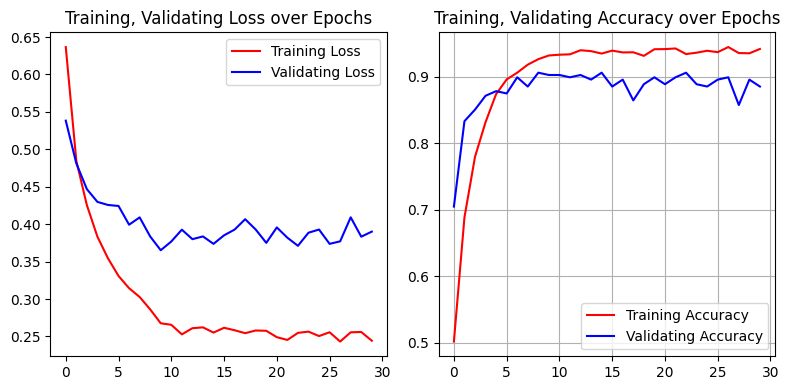

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       108
           1       0.93      0.86      0.89       112

   micro avg       0.93      0.87      0.90       220
   macro avg       0.93      0.87      0.90       220
weighted avg       0.93      0.87      0.90       220
 samples avg       0.78      0.76      0.76       220



c:\Users\Jason\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jason\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jason\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

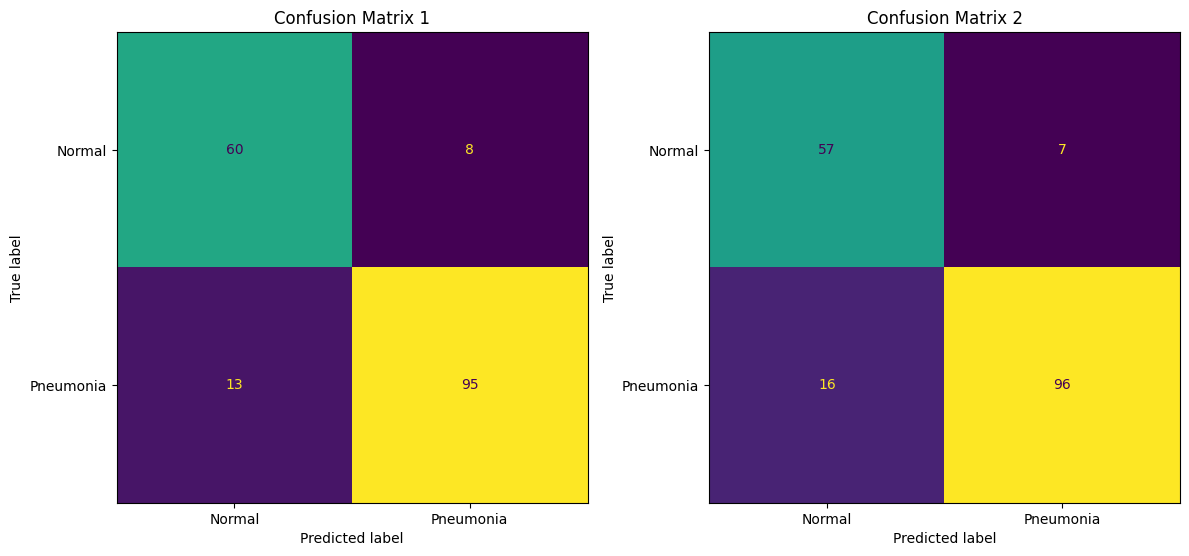

Number of parameters: 3081042


In [30]:
models['resnet18'], results['resnet18'] = evaluation(models["resnet18"], lr=0.0001, momentum=0.9, weight_decay=1e-4, num_epochs=30)

Epoch 1/30: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]


train Loss: 0.4816 Acc: 0.7423


Epoch 1/30: 100%|██████████| 144/144 [01:24<00:00,  1.70it/s]


val Loss: 0.4975 Acc: 0.8368



Epoch 2/30: 100%|██████████| 163/163 [01:20<00:00,  2.04it/s]


train Loss: 0.3879 Acc: 0.8380


Epoch 2/30: 100%|██████████| 144/144 [01:24<00:00,  1.71it/s]


val Loss: 0.4777 Acc: 0.8438



Epoch 3/30: 100%|██████████| 163/163 [01:20<00:00,  2.04it/s]


train Loss: 0.3483 Acc: 0.8817


Epoch 3/30: 100%|██████████| 144/144 [01:24<00:00,  1.71it/s]


val Loss: 0.4404 Acc: 0.8576



Epoch 4/30: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]


train Loss: 0.3276 Acc: 0.8988


Epoch 4/30: 100%|██████████| 144/144 [01:24<00:00,  1.71it/s]


val Loss: 0.4275 Acc: 0.8646



Epoch 5/30: 100%|██████████| 163/163 [01:20<00:00,  2.03it/s]


train Loss: 0.3025 Acc: 0.9149


Epoch 5/30: 100%|██████████| 144/144 [01:24<00:00,  1.70it/s]


val Loss: 0.4449 Acc: 0.8438



Epoch 6/30: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]


train Loss: 0.2848 Acc: 0.9227


Epoch 6/30: 100%|██████████| 144/144 [01:23<00:00,  1.72it/s]


val Loss: 0.4731 Acc: 0.8368



Epoch 7/30: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]


train Loss: 0.2668 Acc: 0.9321


Epoch 7/30: 100%|██████████| 144/144 [01:23<00:00,  1.73it/s]


val Loss: 0.4814 Acc: 0.8160



Epoch 8/30: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]


train Loss: 0.2561 Acc: 0.9369


Epoch 8/30: 100%|██████████| 144/144 [01:24<00:00,  1.71it/s]


val Loss: 0.4333 Acc: 0.8368



Epoch 9/30: 100%|██████████| 163/163 [01:20<00:00,  2.03it/s]


train Loss: 0.2475 Acc: 0.9387


Epoch 9/30: 100%|██████████| 144/144 [01:24<00:00,  1.71it/s]


val Loss: 0.4586 Acc: 0.8160



Epoch 10/30: 100%|██████████| 163/163 [01:20<00:00,  2.02it/s]


train Loss: 0.2333 Acc: 0.9454


Epoch 10/30: 100%|██████████| 144/144 [01:24<00:00,  1.69it/s]


val Loss: 0.4160 Acc: 0.8368



Epoch 11/30: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]


train Loss: 0.2245 Acc: 0.9450


Epoch 11/30: 100%|██████████| 144/144 [01:24<00:00,  1.71it/s]


val Loss: 0.4087 Acc: 0.8403



Epoch 12/30: 100%|██████████| 163/163 [01:20<00:00,  2.03it/s]


train Loss: 0.2272 Acc: 0.9465


Epoch 12/30: 100%|██████████| 144/144 [01:24<00:00,  1.70it/s]


val Loss: 0.4179 Acc: 0.8403



Epoch 13/30: 100%|██████████| 163/163 [01:20<00:00,  2.03it/s]


train Loss: 0.2249 Acc: 0.9515


Epoch 13/30: 100%|██████████| 144/144 [01:24<00:00,  1.70it/s]


val Loss: 0.4334 Acc: 0.8299



Epoch 14/30: 100%|██████████| 163/163 [01:20<00:00,  2.02it/s]


train Loss: 0.2325 Acc: 0.9423


Epoch 14/30: 100%|██████████| 144/144 [01:25<00:00,  1.69it/s]


val Loss: 0.4271 Acc: 0.8368



Epoch 15/30: 100%|██████████| 163/163 [01:22<00:00,  1.99it/s]


train Loss: 0.2242 Acc: 0.9486


Epoch 15/30: 100%|██████████| 144/144 [01:26<00:00,  1.67it/s]


val Loss: 0.4118 Acc: 0.8368



Epoch 16/30: 100%|██████████| 163/163 [01:18<00:00,  2.07it/s]


train Loss: 0.2195 Acc: 0.9477


Epoch 16/30: 100%|██████████| 144/144 [01:23<00:00,  1.73it/s]


val Loss: 0.4100 Acc: 0.8368



Epoch 17/30: 100%|██████████| 163/163 [01:19<00:00,  2.06it/s]


train Loss: 0.2211 Acc: 0.9477


Epoch 17/30: 100%|██████████| 144/144 [01:23<00:00,  1.72it/s]


val Loss: 0.4421 Acc: 0.8229



Epoch 18/30: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]


train Loss: 0.2165 Acc: 0.9484


Epoch 18/30: 100%|██████████| 144/144 [01:23<00:00,  1.72it/s]


val Loss: 0.4181 Acc: 0.8368



Epoch 19/30: 100%|██████████| 163/163 [01:19<00:00,  2.06it/s]


train Loss: 0.2232 Acc: 0.9436


Epoch 19/30: 100%|██████████| 144/144 [01:23<00:00,  1.73it/s]


val Loss: 0.4361 Acc: 0.8368



Epoch 20/30: 100%|██████████| 163/163 [01:17<00:00,  2.09it/s]


train Loss: 0.2136 Acc: 0.9492


Epoch 20/30: 100%|██████████| 144/144 [01:22<00:00,  1.75it/s]


val Loss: 0.4189 Acc: 0.8438



Epoch 21/30: 100%|██████████| 163/163 [01:20<00:00,  2.04it/s]


train Loss: 0.2233 Acc: 0.9457


Epoch 21/30: 100%|██████████| 144/144 [01:24<00:00,  1.71it/s]


val Loss: 0.4377 Acc: 0.8229



Epoch 22/30: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]


train Loss: 0.2073 Acc: 0.9542


Epoch 22/30: 100%|██████████| 144/144 [01:23<00:00,  1.72it/s]


val Loss: 0.4047 Acc: 0.8438



Epoch 23/30: 100%|██████████| 163/163 [01:20<00:00,  2.02it/s]


train Loss: 0.2114 Acc: 0.9490


Epoch 23/30: 100%|██████████| 144/144 [01:25<00:00,  1.69it/s]


val Loss: 0.4158 Acc: 0.8368



Epoch 24/30: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]


train Loss: 0.2225 Acc: 0.9448


Epoch 24/30: 100%|██████████| 144/144 [01:23<00:00,  1.72it/s]


val Loss: 0.3988 Acc: 0.8438



Epoch 25/30: 100%|██████████| 163/163 [01:20<00:00,  2.03it/s]


train Loss: 0.2148 Acc: 0.9519


Epoch 25/30: 100%|██████████| 144/144 [01:24<00:00,  1.70it/s]


val Loss: 0.4334 Acc: 0.8299



Epoch 26/30: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]


train Loss: 0.2129 Acc: 0.9482


Epoch 26/30: 100%|██████████| 144/144 [01:24<00:00,  1.71it/s]


val Loss: 0.4211 Acc: 0.8299



Epoch 27/30: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]


train Loss: 0.2193 Acc: 0.9475


Epoch 27/30: 100%|██████████| 144/144 [01:23<00:00,  1.72it/s]


val Loss: 0.4066 Acc: 0.8403



Epoch 28/30: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]


train Loss: 0.2113 Acc: 0.9509


Epoch 28/30: 100%|██████████| 144/144 [01:23<00:00,  1.71it/s]


val Loss: 0.4293 Acc: 0.8264



Epoch 29/30: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]


train Loss: 0.2216 Acc: 0.9454


Epoch 29/30: 100%|██████████| 144/144 [01:24<00:00,  1.71it/s]


val Loss: 0.4050 Acc: 0.8403



Epoch 30/30: 100%|██████████| 163/163 [01:20<00:00,  2.03it/s]


train Loss: 0.2195 Acc: 0.9465


Epoch 30/30: 100%|██████████| 144/144 [01:24<00:00,  1.71it/s]


val Loss: 0.4124 Acc: 0.8403

Training complete in 42m 6s
Best val Acc: 0.864583
<class 'list'>


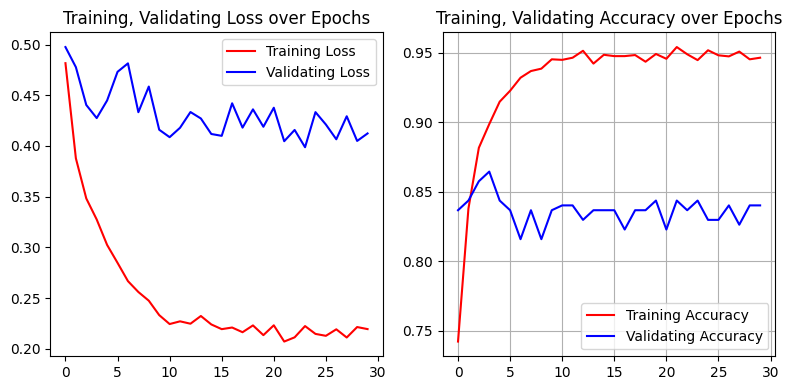

              precision    recall  f1-score   support

           0       0.93      0.84      0.88       110
           1       0.93      0.90      0.91       110

   micro avg       0.93      0.87      0.90       220
   macro avg       0.93      0.87      0.90       220
weighted avg       0.93      0.87      0.90       220
 samples avg       0.77      0.75      0.75       220



c:\Users\Jason\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jason\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jason\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

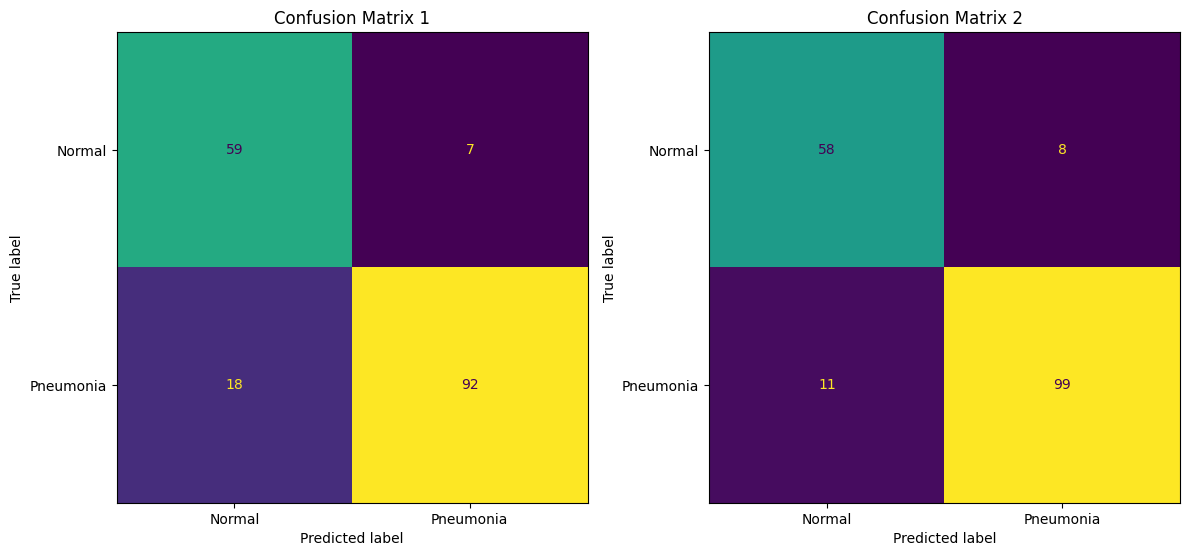

Number of parameters: 13290194


In [31]:
models['resnet50'], results['resnet50'] = evaluation(models["resnet50"], lr=0.0001, momentum=0.9, weight_decay=1e-4, num_epochs=30)